## Creating raster from geometry and GEE satellite data.  

This notebook shows how to create a raster file based on an area of interest geometry to bound a GEE satellite dataset.  

### Notes about GEE  

https://developers.google.com/earth-engine/guides/python_install  

GEE must be installed and have authorization before any access to GEE satellite data.

### GEE satellite dataset  

https://developers.google.com/earth-engine/datasets  

GEE is designed as a tool for data science and machine learning so it is very useful for many projects.  It allows for rapid selection of datasets that meet many common needs.  This notebook will show a simplified approach to extracting the satellite image bounded by a geometry.



### Bounding geometry for area of interest (AOI)  

There are many sources for geometries.  This notebook will use the geometry obtained from gadm.org.  Note that the site currently holds geometries for 2018.  
The common geometry format is called a shapefile.  It is a collection of files that includes .shp, .shx, .dbf, & .cpg.  Developed by ESRI, this is an open format that is convenient in quickly bounding an image.  
https://desktop.arcgis.com/en/arcmap/10.3/manage-data/shapefiles/what-is-a-shapefile.htm  

To load, just link to the .shp file name; however, ensure that all the necessary files are in the same location.  Geopandas automatically looks for the other file formats.
 

#### Download required libraries

In [1]:
!pip install geopandas

     |████████████████████████████████| 994 kB 7.6 MB/s 
     |████████████████████████████████| 15.4 MB 40 kB/s 
     |████████████████████████████████| 6.6 MB 31.1 MB/s 


In [2]:
!pip install rasterio && pip install rioxarray

     |████████████████████████████████| 19.3 MB 1.4 MB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for rioxarray: filename=rioxarray-0.5.0-py3-none-any.whl size=53090 sha256=4301156687bf71a2562207af195f58e54b2b4045d4efb7577e4f70dd10fc66fb
  Stored in directory: /root/.cache/pip/wheels/95/34/d1/2e9ab5c844c963c12880be7890edbf20ec8da92b7e8a279a11
Successfully built rioxarray


In [3]:
# standard imports
import os, sys

# base imports
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from pprint import pprint

# GIS libraries
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
import xarray as xr
import rioxarray as rxr

### File location, setup for Google Drive, adjust for other paths.  

### Mount Google Drive or any other file location before proceeding.  

Fill in the empty command.

In [ ]:
# base dir for input files - optional but useful when moving files
base_dir =  # .... enter path here

# dir for country shapefile with level 2 (district, village, small city, etc), i.e. the target area of interest (AOI).
shp_dir =  # .... enter path here

# data dir for the rasters - highly suggestive to separate rasters from other files
raster_dir =  # ... enter path here

# output data dir - place all outputs from this notebook separate from other files
data_dir = # ... enter path here

# shapefile name
shape_file =  # .... enter path here

# filename of the raster - only using 1 raster in this code - below is an example raster
raster_file = # ... raster filename

## Another import method, GDrive.  

Verifying file, upload and do raster inspection.

This is not used in this example.

In [ ]:
# upload file
from google.colab import files

uploaded = files.upload()

## Shapefile

Begin loading the shapefile and its associated files then inspect.

In [7]:
shapefile = gpd.GeoDataFrame.from_file(shape_file)

In [8]:
shapefile.shape

(666, 14)

In [9]:
shapefile.columns

Index(['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'geometry'],
      dtype='object')

In [10]:
shapefile.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   GID_0      666 non-null    object  
 1   NAME_0     666 non-null    object  
 2   GID_1      666 non-null    object  
 3   NAME_1     666 non-null    object  
 4   NL_NAME_1  0 non-null      object  
 5   GID_2      666 non-null    object  
 6   NAME_2     666 non-null    object  
 7   VARNAME_2  190 non-null    object  
 8   NL_NAME_2  0 non-null      object  
 9   TYPE_2     666 non-null    object  
 10  ENGTYPE_2  666 non-null    object  
 11  CC_2       0 non-null      object  
 12  HASC_2     626 non-null    object  
 13  geometry   666 non-null    geometry
dtypes: geometry(1), object(13)
memory usage: 73.0+ KB


### Examine the shapefile.  

Examine the contents and decide what to extract for analysis, based on the project's objectives.  

In this example, we will only extract the name of the AOI and its geometries.

In [11]:
shapefile.head(3)

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,IND,India,IND.1_1,Andaman and Nicobar,None,IND.1.1_1,Nicobar Islands,None,None,District,District,None,IN.AN.NI,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8..."
1,IND,India,IND.1_1,Andaman and Nicobar,None,IND.1.2_1,North and Middle Andaman,None,None,District,District,None,IN.AN.NM,"MULTIPOLYGON (((92.93898 12.22386, 92.93916 12..."
2,IND,India,IND.1_1,Andaman and Nicobar,None,IND.1.3_1,South Andaman,None,None,District,District,None,IN.AN.SA,"MULTIPOLYGON (((92.47972 10.52056, 92.47945 10..."


In [12]:
# rename for easier recognition, in this example, this is the AOI
shapefile.rename(columns={"NAME_2": "District Name"}, inplace=True)

In [18]:
# only examine relevant columns and store in a separate dataframe
rd = pd.DataFrame()

In [19]:
# apply the data from column 6 (0-based), District Name
rd.insert(len(rd.columns), 'District Name', shapefile.iloc[:,6])

In [21]:
# and the geometry
rd.insert(len(rd.columns), 'geometry', shapefile.iloc[:,13])

#### The final data frame shows the AOI data, name and geometry.  The next step will be to bound the satellite image obtained from the GEE database.

In [22]:
rd.head(3)

,District Name,geometry
0,Nicobar Islands,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8..."
1,North and Middle Andaman,"MULTIPOLYGON (((92.93898 12.22386, 92.93916 12..."
2,South Andaman,"MULTIPOLYGON (((92.47972 10.52056, 92.47945 10..."


In [27]:
rd.shape

(666, 2)

In [36]:
rd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   District Name  666 non-null    object  
 1   geometry       666 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 10.5+ KB


## GEE  

This code is tested in Colab that already has GEE.  For other platforms, follow the link:  
https://developers.google.com/earth-engine/guides/python_install  

After install and import, authenticate, apply the code, and extract the AOI.

In [ ]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

#### Below are some examples of the satellite sources as well as some meta data attributes.  

https://developers.google.com/earth-engine/tutorials/tutorial_api_02

In [24]:
L8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_TOA").filterMetadata('CLOUD_COVER','less_than',10)
L7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_TOA").filterMetadata('CLOUD_COVER','less_than',10)
L51 = ee.ImageCollection("LANDSAT/LT05/C01/T1_TOA").select(['B3', 'B2', 'B1']).filterMetadata('CLOUD_COVER','less_than',10)

Depending on the satellite source, the data range may vary.  Consult the dataset information.  

https://developers.google.com/earth-engine/datasets?hl=en

In [88]:
time_range = ['2018-01-01', '2018-12-31']

### Extraction of a raster from an AOI based on a geometry (from shapefile).  

In this example, the code uses image collection of satellite images.  
https://developers.google.com/earth-engine/tutorials/tutorial_api_04  

This is a commen method of extracting datasets because it covers a certain range of time rather than a single event.  The geometry bounds this collection to create a final raster that only contains attributes for the AOI.  Because it uses GEE, the type has to be converted to JSON.  

The code below is an extension from this Q&A link:  
https://gis.stackexchange.com/questions/333791/accessing-a-shapefile-with-googleearthengine-api-invalid-geojson-geometry/334400#334400


In [110]:
rd.head(3)

,District Name,geometry
0,Nicobar Islands,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8..."
1,North and Middle Andaman,"MULTIPOLYGON (((92.93898 12.22386, 92.93916 12..."
2,South Andaman,"MULTIPOLYGON (((92.47972 10.52056, 92.47945 10..."


In [111]:
# interested only in 1 boundary for this sample notebook, randomly choosing row 11 (0-based -> 10)
rd.iloc[10,:]

District Name                                             Prakasam
geometry         (POLYGON ((80.05986023 15.19986153, 80.0598602...
Name: 10, dtype: object

In [98]:
# the rd data frame contains 666 AOI, only interested in 1 sample
# showing the structure to extract all the AOI geometries
district = []
regions = []
# use a loop method here for multiple AOIs
g =  rd.iloc[10,:]
geom = gpd.GeoSeries(g['geometry'])           # reflecting the new geopandas API for json conversion
                                              # https://geopandas.org/gallery/polygon_plotting_with_folium.html?highlight=to_json
jsonDict = eval(geom.to_json())
geojsonDict = jsonDict['features'][0]
regions.append(ee.FeatureCollection(ee.Feature(geojsonDict)).geometry())
d = str(g['District Name']).lower().strip()
district.append(d.replace(' ', '_'))          # remove non alphanum char

In [99]:
district

['prakasam']

In [100]:
type(regions[0])

ee.geometry.Geometry

### Extract GEE raster, this sample uses Colab and Google drive.  

Modify for other environments.  

Create a url link to the GEE environment, download, and show.

In [103]:
### URL LINK
# only the sampled region, create a loop or a function to process each AOI
region = regions[0]

image_area = L8.filterDate(time_range[0], time_range[1]).filterBounds(region)

# since this is a collection and want only 1 raster at the end, using median to stack the images    
image_median = image_area.median()

# clip to the region
clip = image_median.clip(region).toFloat()

# adjusted in order to meet the raster size limits
scale = 250
raster_url = clip.getDownloadURL({
                'crs' : 'EPSG:4326',
                'scale': scale,
                'region':region
                   })

In [105]:
### DOWNLOAD
# Extracting the zip file from URL, this takes time
import requests, zipfile, io
 
r = requests.get(raster_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(raster_dir)

# Name of downloaded file
downloaded_tif = os.path.join(raster_dir, z.filelist[0].filename)

# Renaming the downloaded file
renamed_tif = os.path.join(raster_dir, district[i]+'_'+str(time_range[0].split('-')[0])+'.tif')
os.rename(downloaded_tif, renamed_tif)

Verify: read and plot

In [106]:
# note the naming scheme, '.tif' is appended, this is the default raster format and GEE uses it as default
# Open the file:
raster = rasterio.open(renamed_tif)

In [107]:
# from rasterio doc: attributes
print(f'Raster shape:\t\t {raster.shape}')
print(f'Raster band count:\t {raster.count}')
print(f'Raster data types:\t {raster.dtypes} ')
print(f'Raster valid data mask:\t {raster.nodatavals}')
print(f'Raster not valid mask:\t {raster.nodata}')

Raster shape:		 (609, 775)
Raster band count:	 1
Raster data types:	 ('float32',) 
Raster valid data mask:	 (None,)
Raster not valid mask:	 None


In [108]:
print(f'Raster metadata:\n')
pprint(raster.meta)

Raster metadata:

{'count': 1,
 'crs': CRS.from_epsg(4326),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 609,
 'nodata': None,
 'transform': Affine(0.002245788210298804, 0.0, 78.73284307665547,
       0.0, -0.002245788210298804, 16.311159771400213),
 'width': 775}


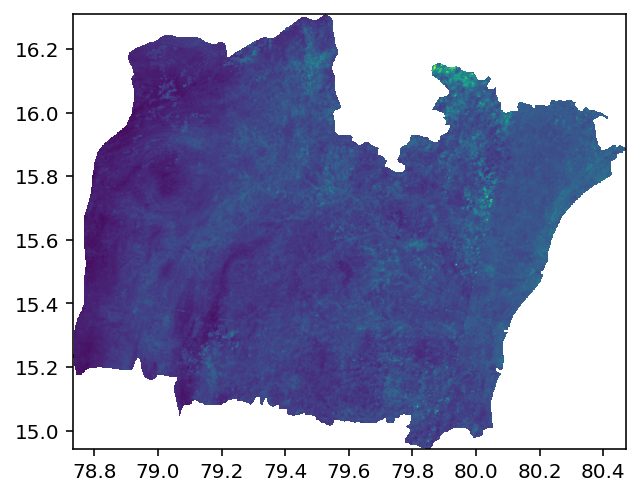

In [109]:
# the plot dimensions show the longitude, x, and lattitude, y, inspect
show(raster);

In [112]:
type(raster)

rasterio.io.DatasetReader

In [113]:
raster.close()

## Raster dataset  

Now that the raster is available, proceed to analysis depending on the project objectives.